In [2]:
# pandas for data loading, manipulation etc.
import pandas as pd


# numeric functions
import xgboost
import numpy as np
import collections
import math
import operator
from scipy import stats
from math import ceil
import time
import random as rnd

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
%matplotlib inline


# modelling
from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet,Lars,LassoLars,SGDRegressor
from sklearn.linear_model import RidgeCV, LassoCV,BayesianRidge, LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score,train_test_split,KFold
from sklearn.metrics import make_scorer,r2_score,mean_squared_error,roc_auc_score, accuracy_score,explained_variance_score
from sklearn.neighbors import KNeighborsRegressor #,KNearestNeighborsRegressor


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PolynomialFeatures, minmax_scale
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import RFE,SelectFromModel
from statsmodels.formula.api import poisson, negativebinomial

import xgboost as xgb
from xgboost import XGBRegressor

import warnings
#warnings.filterwarnings("ignore")

In [3]:
datos = pd.read_csv('datacountstudents.csv')
datos = datos.iloc[:,1:]
# prepare for modeling
X = datos.drop(['yC'], axis=1)
Y = datos['yC'].values

In [4]:
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 33 columns):
yC     150 non-null int64
x1     150 non-null float64
x2     150 non-null float64
x3     150 non-null int64
x4     150 non-null int64
x5     150 non-null int64
x6     150 non-null int64
x7     150 non-null int64
x8     150 non-null float64
x9     150 non-null int64
x10    150 non-null float64
x11    150 non-null float64
x12    150 non-null float64
x13    150 non-null int64
x14    150 non-null int64
x15    150 non-null int64
x16    150 non-null int64
x17    150 non-null int64
x18    150 non-null int64
x19    150 non-null int64
x20    150 non-null int64
x21    150 non-null float64
x22    150 non-null float64
x23    150 non-null float64
x24    150 non-null float64
x25    150 non-null int64
x26    150 non-null int64
x27    150 non-null float64
x28    150 non-null int64
x29    150 non-null int64
x30    150 non-null int64
x31    150 non-null float64
x32    150 non-null float64
dtypes: flo

In [5]:
#dtype discrete to continuos for count variables 
datos = pd.read_csv('datacountstudents.csv', dtype={'x9':float,'x25':float,'x26':float,'x30':float})
datos = datos.iloc[:,1:]

In [6]:
X = datos.drop(['yC'], axis=1)
y = datos['yC'].values
# prepare for modeling
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.4, random_state=101)

X_test, X_val, y_test, y_val= train_test_split(X_test, y_test, test_size=0.5, random_state=101)

In [7]:
#name of continuos variables
train_C = X_train.select_dtypes(exclude=['int64'])
Columns_C = X_train.columns[(X_train.dtypes.values == np.dtype('float64'))]
#Columns_D = X_train.columns[(X_train.dtypes.values != np.dtype('float64'))]
# Standardize only continuous training
X_train_sc = X_train.copy()
col_names = Columns_C[0:13]
features_tr = X_train_sc[col_names]
scaler = StandardScaler().fit(features_tr.values)
features_tr = scaler.transform(features_tr.values)
X_train_sc[col_names] = features_tr
# Standardize only continuous testing
X_test_sc = X_test.copy()
features_ts = X_test_sc[col_names]
features_ts = scaler.transform(features_ts.values)
X_test_sc[col_names] = features_ts
# standarice counting validation variables 
X_val_sc = X_val.copy()
features_va = X_val_sc[col_names]
features_va = scaler.transform(features_va.values)
X_val_sc[col_names] = features_va
#dataframes
X_train_sc = pd.concat([X_train_sc], axis=1, sort=False)
X_test_sc = pd.concat([X_test_sc], axis=1, sort=False)
X_val_sc = pd.concat([X_val_sc], axis=1, sort=False)
#X_train_sc.head()

In [9]:
train_x=X_train_sc
train_y=y_train   
Xts = X_test_sc
Yt = y_test

In [8]:
#for tuning parameters
parameters_for_testing = {
    'colsample_bytree':[0.4,0.6,0.8],
    'gamma':[0,0.03,0.1,0.3],
    'min_child_weight':[1.5,6,10],
    'learning_rate':[0.1,0.07],
    'max_depth':[2,3,5],
    'n_estimators':[10000],
    'reg_alpha':[1e-5, 1e-2,  0.75],
    'reg_lambda':[1e-5, 1e-2, 0.45],
    'subsample':[0.6,0.95]  
}

#https://www.datacamp.com/community/tutorials/xgboost-in-python borrar

In [11]:
#choosing best parameters to built a model
xgb_model = xgboost.XGBRegressor(learning_rate =0.1, n_estimators=10, max_depth=5,
     min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8, nthread=6, scale_pos_weight=1, seed=27)

gsearch1 = GridSearchCV(estimator = xgb_model, param_grid = parameters_for_testing, n_jobs=6,iid=False, verbose=10,scoring='neg_mean_squared_error')
gsearch1.fit(train_x,train_y)
print (gsearch1.scorer_ ) # print (gsearch1.grid_scores_)
print('best params')
print (gsearch1.best_params_)
print('best score')
print (gsearch1.best_score_)

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


Fitting 3 folds for each of 3888 candidates, totalling 11664 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   17.4s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:   17.6s
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:   26.3s
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed:   32.4s
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed:   38.2s
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:   49.6s
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed:  1.0min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed:  1.1min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed:  1.5min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed:  1.9min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed:  2.2min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed:  2.4min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:  2.9min
[Parallel(n_jobs=6)]: Do

[Parallel(n_jobs=6)]: Done 9373 tasks      | elapsed: 457.2min
[Parallel(n_jobs=6)]: Done 9510 tasks      | elapsed: 465.5min
[Parallel(n_jobs=6)]: Done 9649 tasks      | elapsed: 479.8min
[Parallel(n_jobs=6)]: Done 9788 tasks      | elapsed: 488.0min
[Parallel(n_jobs=6)]: Done 9929 tasks      | elapsed: 495.8min
[Parallel(n_jobs=6)]: Done 10070 tasks      | elapsed: 506.9min
[Parallel(n_jobs=6)]: Done 10213 tasks      | elapsed: 521.4min
[Parallel(n_jobs=6)]: Done 10356 tasks      | elapsed: 529.4min
[Parallel(n_jobs=6)]: Done 10501 tasks      | elapsed: 541.8min
[Parallel(n_jobs=6)]: Done 10646 tasks      | elapsed: 556.4min
[Parallel(n_jobs=6)]: Done 10793 tasks      | elapsed: 565.2min
[Parallel(n_jobs=6)]: Done 10940 tasks      | elapsed: 575.9min
[Parallel(n_jobs=6)]: Done 11089 tasks      | elapsed: 593.0min
[Parallel(n_jobs=6)]: Done 11238 tasks      | elapsed: 606.7min
[Parallel(n_jobs=6)]: Done 11389 tasks      | elapsed: 614.7min
[Parallel(n_jobs=6)]: Done 11540 tasks      |

[09:41:55] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
make_scorer(mean_squared_error, greater_is_better=False)
best params
{'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 10000, 'reg_alpha': 0.75, 'reg_lambda': 0.01, 'subsample': 0.95}
best score
-2.0016773052936006


In [9]:
#dataframe dependents and label training
data_dmatrix = xgb.DMatrix(data=X_train_sc,label=y_train)
params ={'colsample_bytree': 0.4, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1.5, 'n_estimators': 10000, 'reg_alpha': 0.75, 'reg_lambda': 0.01, 'subsample': 0.95}

In [10]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

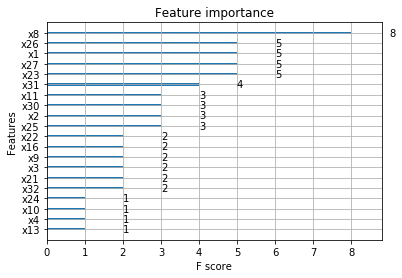

In [11]:
#variable selection
xgb.plot_importance(xg_reg)
plt.rcParams['figure.figsize'] = [20, 20]
plt.show()

In [14]:
#Describe the model
xg_reg = xgb.XGBRegressor(objective ='count:poisson')
columns=['x8','x26','x1','x27','x31','x11','x30','x2','x25','x22','x16','x9','x3','x21']
X_train_sc3=pd.DataFrame(X_train_sc,columns=columns)
X_test_sc3=pd.DataFrame(X_test_sc,columns=columns)
X_val_sc3=pd.DataFrame(X_val_sc,columns=columns)
#Fit the model
xg_reg.fit(X_train_sc3,y_train)
#Make model predictions
preds = xg_reg.predict(X_test_sc3)
y_ts = pd.DataFrame(y_test,columns=['y_ts'])
pred= pd.DataFrame(np.round(preds),columns=['predict'])
#pred
columns=['y_ts','pred']
#dataframe y_test Vs Y_predict
Result1= pd.concat([y_ts,pred], axis=1, sort=False)
Result1['xg_reg_1']= [0]*len(Result1)
sum=0
for i in range(len(Result1)):
    if Result1.predict[i]<=0:
        if Result1.y_ts[i]<=0:
            Result1['xg_reg_1'][i]=1
            sum=sum+1
        else: Result1['xg_reg_1'] [i]=0
    elif Result1.predict[i]>0:
        if Result1.y_ts[i]>0:
            Result1['xg_reg_1'][i]=1
            sum=sum+1        
    else: Result1['xg_reg_1'] [i]=0
print("Explained_variance_score: ",explained_variance_score(y_test,pred))
print("Test 0 y >0: ",sum/len(Result1))
print("MSE_test:",np.sqrt(mean_squared_error(y_test, pred)))

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Explained_variance_score:  0.40486925157799825
Test 0 y >0:  0.6333333333333333
MSE_test: 0.8563488385776752


In [15]:
# predict Y Validation
y_val = pd.DataFrame(y_val,columns=['y_val'])
preds_v = xg_reg.predict(X_val_sc3)   
#predict is discretised 
preds_v= pd.DataFrame(np.round(preds_v),columns=['predict'])
               
columns=['y_val','preds_v']# X_train_sc,label=y_train
Result2= pd.concat([y_val,preds_v], axis=1, sort=False)

sum=0
Result2['xg_reg_val']= [0]*len(Result2)
for i in range(len(Result2)):
    if Result2.predict[i]<=0:
        if Result2.y_val[i]<=0:
            Result2['xg_reg_val'][i]=1
            sum=sum+1
        else: Result2['xg_reg_val'] [i]=0
    elif Result2.predict[i]>0:
        if Result2.y_val[i]>0:
            Result2['xg_reg_val'][i]=1
            sum=sum+1        
    else: Result2['xg_reg_val'] [i]=0
print("Explained_variance_score: ",explained_variance_score(y_val, preds_v))        
print("Val 0 y >0: ",sum/len(Result2))
print("MSE_val:",np.sqrt(mean_squared_error(y_val, preds_v)))


C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Explained_variance_score:  -0.23624047417442906
Val 0 y >0:  0.6333333333333333
MSE_val: 1.3165611772087666


In [16]:
#Train Dataframe
#To erase index of X_train
X_train_sc2=X_train_sc.reset_index().values
#y_train as a dataframe
y_train2= pd.DataFrame(y_train,columns=['y_train'])
columns=['id','x1','x2','x3','x4','x5','x6','x7','x8','x9','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19',
         'x20','x21','x22','x23','x24','x25','x26','x27','x28', 'x29', 'x30', 'x31','x32']
#change name of colums of X_train
X_train_sc2= pd.DataFrame(X_train_sc2,columns=columns)#
#drop id
X_train_sc2=X_train_sc2.drop(['id'], axis=1)
#Dataframe y with x's
X_train_sc2 = pd.concat([y_train2,X_train_sc2], axis=1, sort=False)

# Test DataFrame
X_test_sc2=X_test_sc.reset_index().values
y_test2= pd.DataFrame(y_test,columns=['y_test'])
X_test_sc2= pd.DataFrame(X_test_sc2,columns=columns)
X_test_sc2=X_test_sc2.drop(['id'], axis=1)
X_test_sc2 = pd.concat([y_test2,X_test_sc2], axis=1, sort=False)
#Value DataFrame

X_val_sc2=X_val_sc.reset_index().values
y_val2= pd.DataFrame(y_val,columns=['y_val'])
X_val_sc2= pd.DataFrame(X_val_sc2,columns=columns)
X_val_sc2=X_val_sc2.drop(['id'], axis=1)
X_val_sc2 = pd.concat([y_val2,X_val_sc2], axis=1, sort=False)

# Probando modelo con 

In [17]:
m_nb2 = negativebinomial('y_train2~x8+x26+x1+x27+x11+x31+x30+x2+x25+x22+x16+x9+x3+x21', data = X_train_sc2).fit()
print (m_nb2.summary())

         Current function value: 1.319992
         Iterations: 35
         Function evaluations: 43
         Gradient evaluations: 43
                     NegativeBinomial Regression Results                      
Dep. Variable:               y_train2   No. Observations:                   90
Model:               NegativeBinomial   Df Residuals:                       75
Method:                           MLE   Df Model:                           14
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.1616
Time:                        11:55:45   Log-Likelihood:                -118.80
converged:                      False   LL-Null:                       -141.70
                                        LLR p-value:                 3.015e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0176      0.344      0.051      0.959      -0.656       0.6

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [18]:
preds_nb_t = m_nb2.predict(X_test_sc)
preds_nb_t=preds_nb_t.reset_index().values
y_test_nb_t = pd.DataFrame(y_test,columns=['y_test'])
preds_nb_t= pd.DataFrame(preds_nb_t,columns=['id','pred_nb_t'])
Result_nb_t = pd.concat([y_test_nb_t,np.round(preds_nb_t.iloc[:,1])], axis=1, sort=False)

preds_nb_v = m_nb2.predict(X_val_sc)
preds_nb_v=preds_nb_v.reset_index().values
y_val_nb_v = pd.DataFrame(y_val,columns=['y_val'])
preds_nb_v= pd.DataFrame(preds_nb_v,columns=['id','pred_nb_v'])
Result_nb_v = pd.concat([y_val_nb_v,np.round(preds_nb_v.iloc[:,1])], axis=1, sort=False)


C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Val 0 y >0:  0.6
Predicted   0   1
Actual           
0           2   1
1          11  16


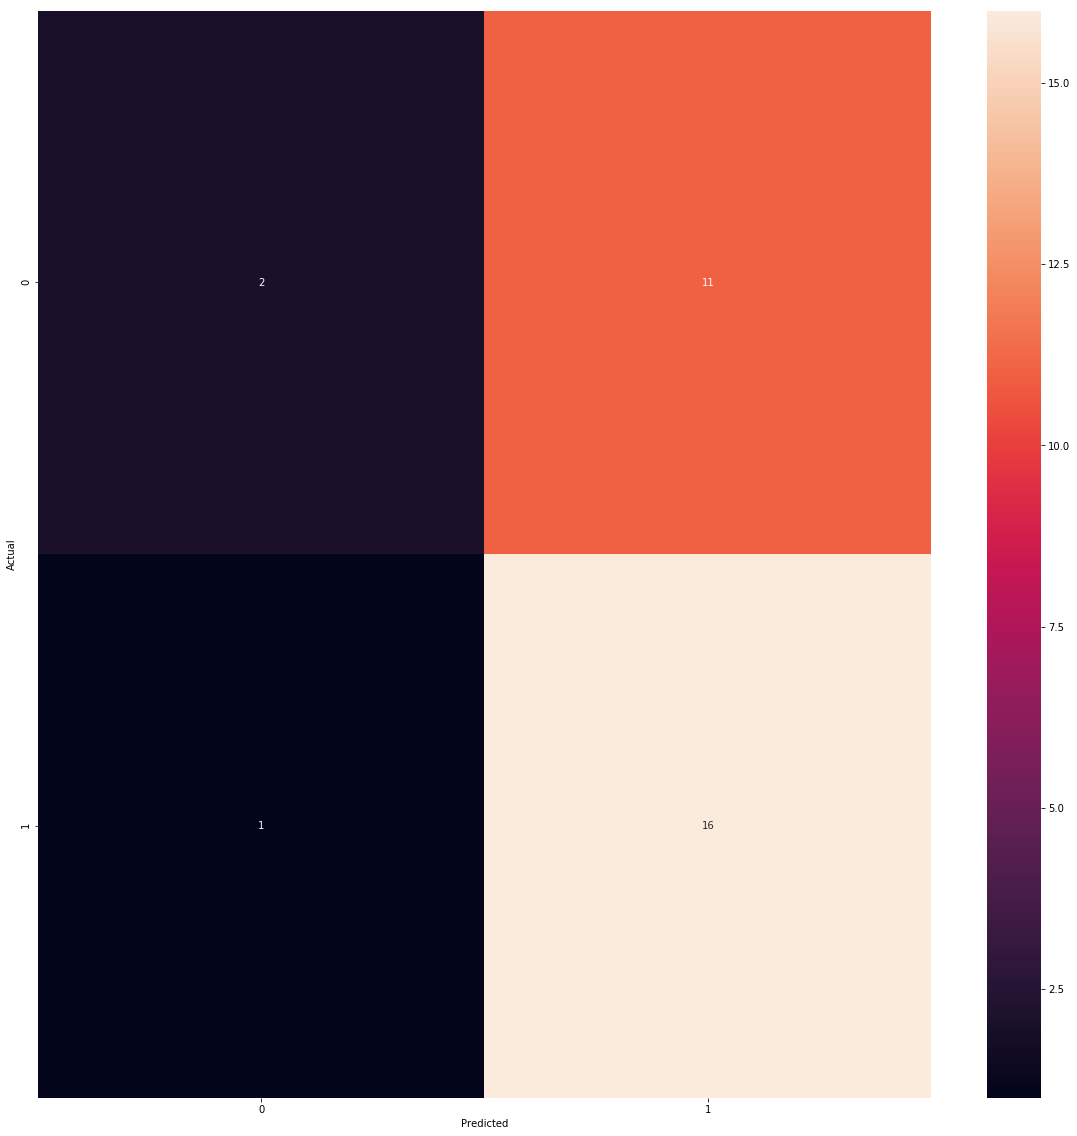

In [19]:
Result_nb_t['Mayor0_test'] = (Result_nb_t['pred_nb_t']>0).astype(int)
Result_nb_t['Mayor0_real'] = (Result_nb_t['y_test']>0).astype(int)
Result_nb_t['prueba']= [0]*len(Result_nb_t['Mayor0_real'])
sum=0
for i in range(len(Result_nb_t['Mayor0_real'])):
    if Result_nb_t.Mayor0_real[i]==Result_nb_t.Mayor0_test[i]:
        Result_nb_t['prueba'][i]=1
        sum=sum+1
    else: Result_nb_t['prueba'] [i]=0
accu=sum/len(Result_nb_t['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result_nb_t['Mayor0_test'],Result_nb_t['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result_nb_t, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Val 0 y >0:  0.7333333333333333
Predicted  0   1
Actual          
0          2   4
1          4  20


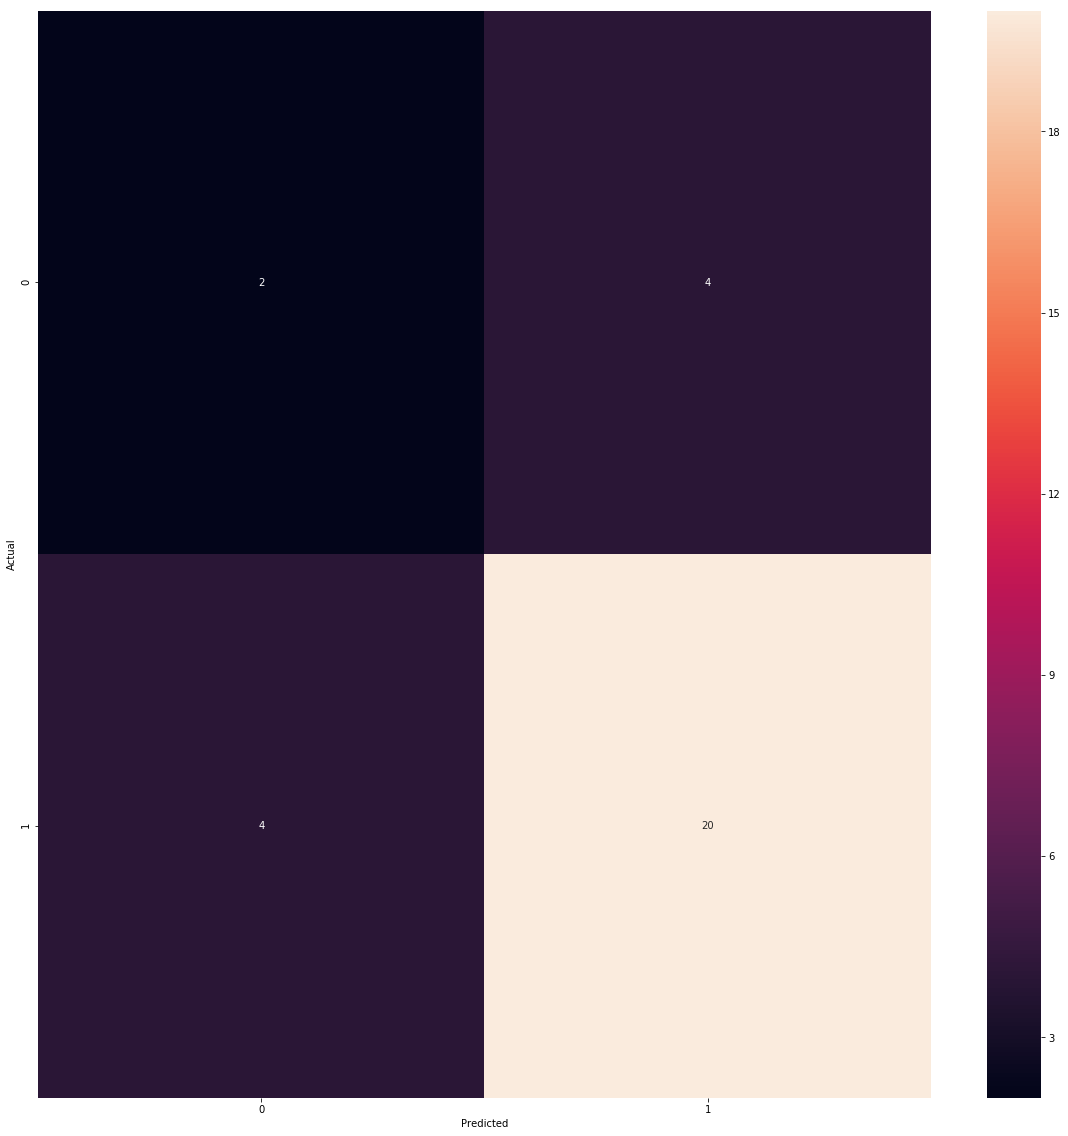

In [20]:
Result_nb_v['Mayor0_val'] = (Result_nb_v['pred_nb_v']>0).astype(int)
Result_nb_v['Mayor0_real'] = (Result_nb_v['y_val']>0).astype(int)
Result_nb_v['prueba']= [0]*len(Result_nb_v['Mayor0_real'])
sum=0
for i in range(len(Result_nb_v['Mayor0_real'])):
    if Result_nb_v.Mayor0_real[i]==Result_nb_v.Mayor0_val[i]:
        Result_nb_v['prueba'][i]=1
        sum=sum+1
    else: Result_nb_v['prueba'] [i]=0
accu=sum/len(Result_nb_v['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result_nb_v['Mayor0_val'],Result_nb_v['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result_nb_v, columns=['Mayor0_val','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_val'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [21]:
#Describe the model→
m_p = poisson('y_train2~x8+x26+x1+x27+x11+x31+x30+x2+x25+x22+x16+x9+x3+x21', data = X_train_sc2).fit()
#Summarize the model
print (m_p.summary())

Optimization terminated successfully.
         Current function value: 1.319989
         Iterations 7
                          Poisson Regression Results                          
Dep. Variable:               y_train2   No. Observations:                   90
Model:                        Poisson   Df Residuals:                       75
Method:                           MLE   Df Model:                           14
Date:                Wed, 02 Oct 2019   Pseudo R-squ.:                  0.1862
Time:                        11:56:07   Log-Likelihood:                -118.80
converged:                       True   LL-Null:                       -145.98
                                        LLR p-value:                 1.118e-06
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0170      0.344      0.049      0.961      -0.657       0.691
x8             0.1020      0.

In [22]:
preds_p_t = m_p.predict(X_test_sc)
preds_p_t=preds_p_t.reset_index().values
y_test_p_t = pd.DataFrame(y_test,columns=['y_test'])
preds_p_t= pd.DataFrame(preds_p_t,columns=['id','pred_p_t'])
Result_p_t = pd.concat([y_test_p_t,np.round(preds_p_t.iloc[:,1])], axis=1, sort=False)

preds_p_v = m_p.predict(X_val_sc)
preds_p_v=preds_p_v.reset_index().values
y_val_p_v = pd.DataFrame(y_val,columns=['y_val'])
preds_p_v= pd.DataFrame(preds_p_v,columns=['id','pred_p_v'])
Result_p_v = pd.concat([y_val_p_v,np.round(preds_p_v.iloc[:,1])], axis=1, sort=False)

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Val 0 y >0:  0.6
Predicted   0   1
Actual           
0           2   1
1          11  16


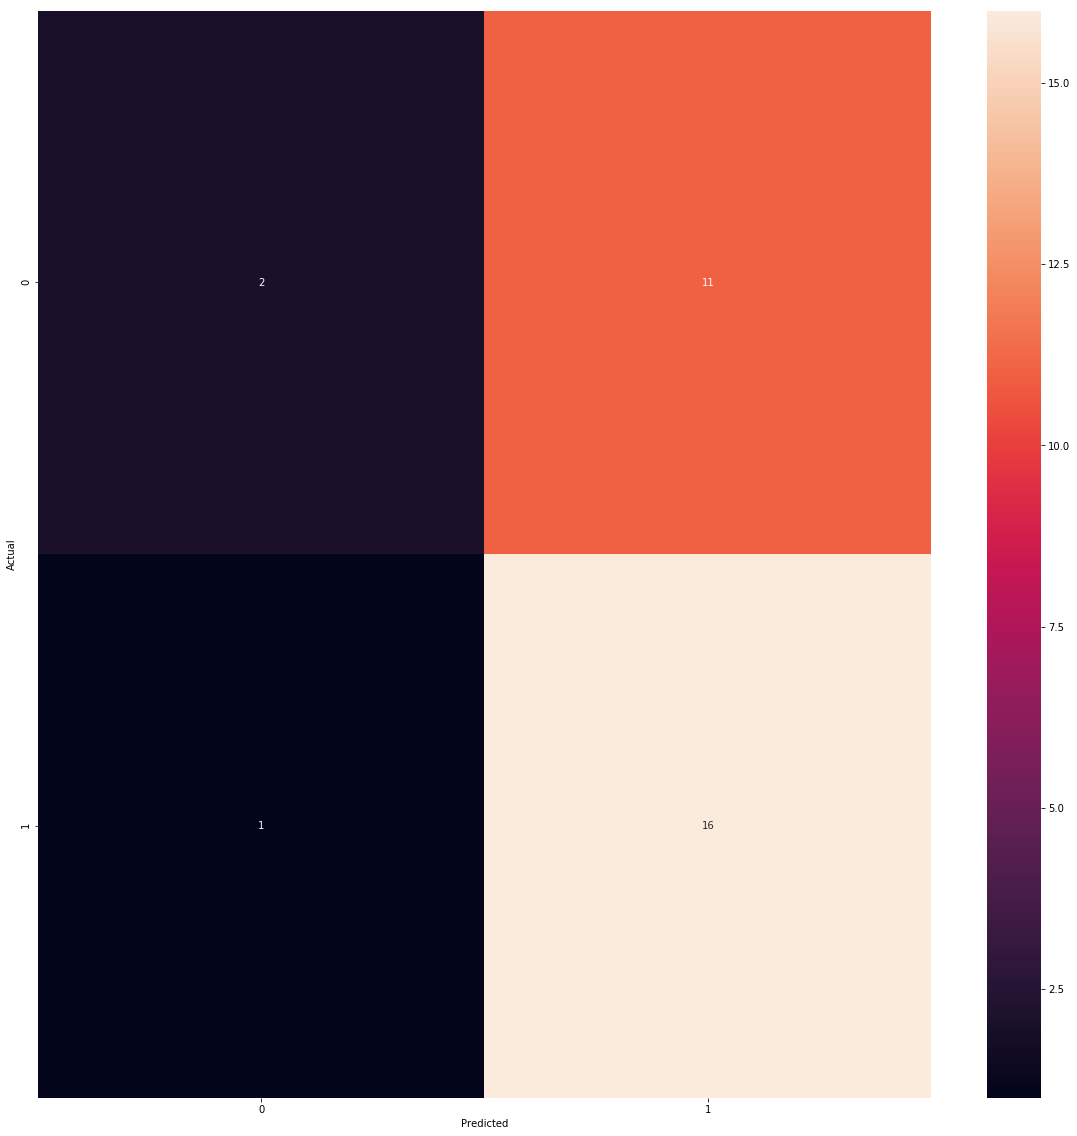

In [23]:
Result_p_t['Mayor0_test'] = (Result_p_t['pred_p_t']>0).astype(int)
Result_p_t['Mayor0_real'] = (Result_p_t['y_test']>0).astype(int)
Result_p_t['prueba']= [0]*len(Result_p_t['Mayor0_real'])
sum=0
for i in range(len(Result_p_t['Mayor0_real'])):
    if Result_p_t.Mayor0_real[i]==Result_p_t.Mayor0_test[i]:
        Result_p_t['prueba'][i]=1
        sum=sum+1
    else: Result_p_t['prueba'] [i]=0
accu=sum/len(Result_p_t['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result_p_t['Mayor0_test'],Result_p_t['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result_p_t, columns=['Mayor0_test','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_test'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\lmosquera\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Val 0 y >0:  0.7333333333333333
Predicted  0   1
Actual          
0          2   4
1          4  20


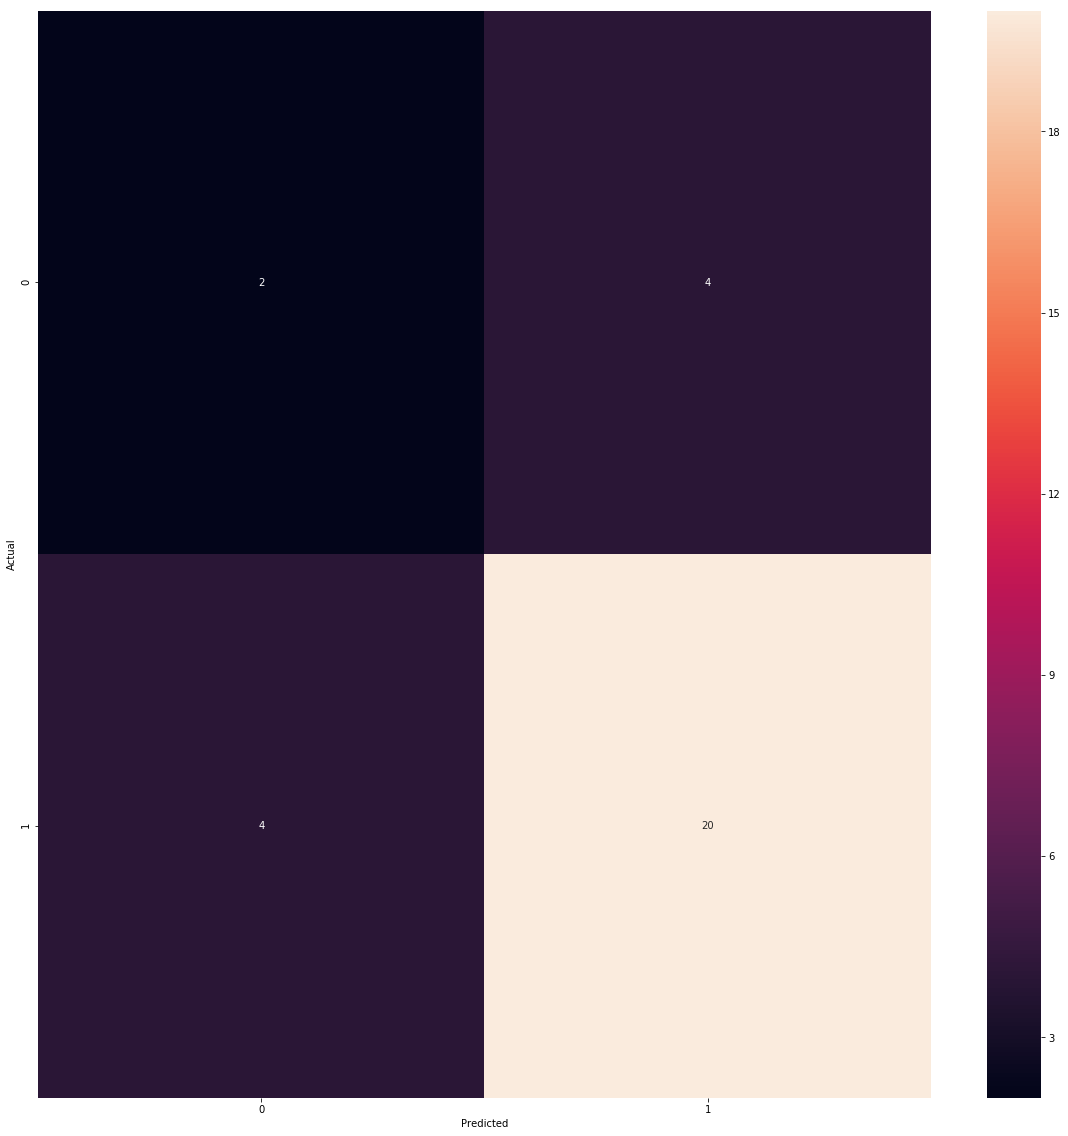

In [24]:
Result_p_v['Mayor0_val'] = (Result_p_v['pred_p_v']>0).astype(int)
Result_p_v['Mayor0_real'] = (Result_p_v['y_val']>0).astype(int)
Result_p_v['prueba']= [0]*len(Result_p_v['Mayor0_real'])
sum=0
for i in range(len(Result_p_v['Mayor0_real'])):
    if Result_p_v.Mayor0_real[i]==Result_p_v.Mayor0_val[i]:
        Result_p_v['prueba'][i]=1
        sum=sum+1
    else: Result_p_v['prueba'] [i]=0
accu=sum/len(Result_p_v['Mayor0_real'])
print("Val 0 y >0: ",accu)
confusion_matrix = pd.crosstab(Result_p_v['Mayor0_val'],Result_p_v['Mayor0_real'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)
df = pd.DataFrame(Result_p_v, columns=['Mayor0_val','Mayor0_real'])
confusion_matrix = pd.crosstab(df['Mayor0_real'], df['Mayor0_val'], rownames=['Actual'], colnames=['Predicted'])

sns.heatmap(confusion_matrix, annot=True)

In [25]:
cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

In [26]:
cv_results.head()

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,1.563093,0.082086,1.612859,0.178196
1,1.489386,0.074397,1.574182,0.165979
2,1.408111,0.072137,1.544139,0.154035
3,1.334776,0.053532,1.504580,0.159300
4,1.259020,0.045337,1.498223,0.153546


In [27]:
print((cv_results["test-rmse-mean"]).tail(5))

13    1.442949
14    1.440923
15    1.441901
16    1.441417
17    1.438060
Name: test-rmse-mean, dtype: float64
